# Titanic Dataset Classification with Single Layer Perceptron
In this notebook, we will analyze the Titanic dataset and build a model using a Single Layer Perceptron (SLP) to predict passenger survival.

In [127]:
# Check GPU
!nvidia-smi

Tue Nov 26 10:50:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8             10W /   35W |     315MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Importing the required libraries

In [128]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# For data handling
import pandas as pd
import numpy as np

# For data preprocessing and scaling
from sklearn.preprocessing import StandardScaler

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For data splitting (if needed)
from sklearn.model_selection import train_test_split

# For model building
import tensorflow as tf


# Data Understanding


## 1. Data Dictionary
The Titanic dataset consists of the following columns:

| Column        | Description                                                  |
|---------------|--------------------------------------------------------------|
| `PassengerId` | A unique identifier for each passenger                       |
| `Survived`    | Survival status (0 = Not survived, 1 = Survived) — Target variable |
| `Pclass`      | Passenger class (1st, 2nd, or 3rd)                           |
| `Name`        | Name of the passenger                                        |
| `Sex`         | Gender of the passenger (male/female)                        |
| `Age`         | Age of the passenger (in years)                              |
| `SibSp`       | Number of siblings or spouses aboard the Titanic             |
| `Parch`       | Number of parents or children aboard the Titanic             |
| `Fare`        | Fare paid for the ticket                                     |
| `Embarked`    | Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |

The **target variable** is `Survived`, which indicates whether the passenger survived or not.

## 2. Data Initialization

In [129]:
train_data = pd.read_csv('data/train_data.csv')

test_data = pd.read_csv('data/test_data.csv')
ground_truth = pd.read_csv('data/ground_truth.csv')

# combine test data and ground truth based on the PassengerId
test_data = pd.merge(test_data, ground_truth, on='PassengerId')

print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (712, 12)
Test data shape:  (331, 12)


In [130]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Exploratory Data Analysis

### Overview of the data

In [131]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB


### Summary Statistics

In [132]:
# Summary statistics for numerical columns
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Check for Missing Values

In [133]:
# Check for missing values train data and test data
print("Missing values in train data: \n", train_data.isnull().sum())
print("\nMissing values in test data: \n", test_data.isnull().sum())

Missing values in train data: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          529
Embarked         0
dtype: int64

Missing values in test data: 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          244
Embarked         0
Survived         0
dtype: int64


#### Handling Cabin

url: https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial

`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the `cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.

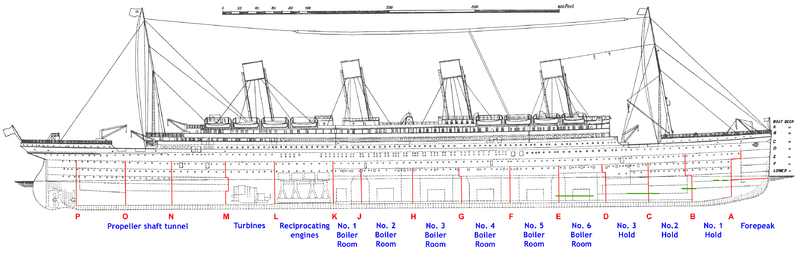

- On the Boat Deck there were **6** rooms labeled as **T**, **U**, **W**, **X**, **Y**, **Z** but only the **T** cabin is present in the dataset
- **A**, **B** and **C** decks were only for 1st class passengers
- **D** and **E** decks were for all classes
- **F** and **G** decks were for both 2nd and 3rd class passengers
- From going **A** to **G**, distance to the staircase increases which might be a factor of survival

In [134]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
train_data['Deck'] = train_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
test_data['Deck'] = test_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

train_data_decks = train_data.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
test_data_decks = test_data.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

idx = train_data[train_data['Deck'] == 'T'].index
train_data.loc[idx, 'Deck'] = 'A'
tratrain_data_decks_survived =train_data.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()
idx = test_data[test_data['Deck'] == 'T'].index
test_data.loc[idx, 'Deck'] = 'A'
tratest_data_decks_survived =train_data.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

train_data['Deck'] = train_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
train_data['Deck'] = train_data['Deck'].replace(['D', 'E'], 'DE')
train_data['Deck'] = train_data['Deck'].replace(['F', 'G'], 'FG')

test_data['Deck'] = test_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
test_data['Deck'] = test_data['Deck'].replace(['D', 'E'], 'DE')
test_data['Deck'] = test_data['Deck'].replace(['F', 'G'], 'FG')

train_data.drop(['Cabin'], inplace=True, axis=1)
test_data.drop(['Cabin'], inplace=True, axis=1)

### Analyze Distribution of Key Features

In [135]:
def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived,width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived,  width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

def plot_survived_distribution(data):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    data['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title('Survived')
    ax[0].set_ylabel('')
    sns.countplot(x='Survived', data=data, ax=ax[1])
    ax[1].set_title('Survived')
    plt.show()

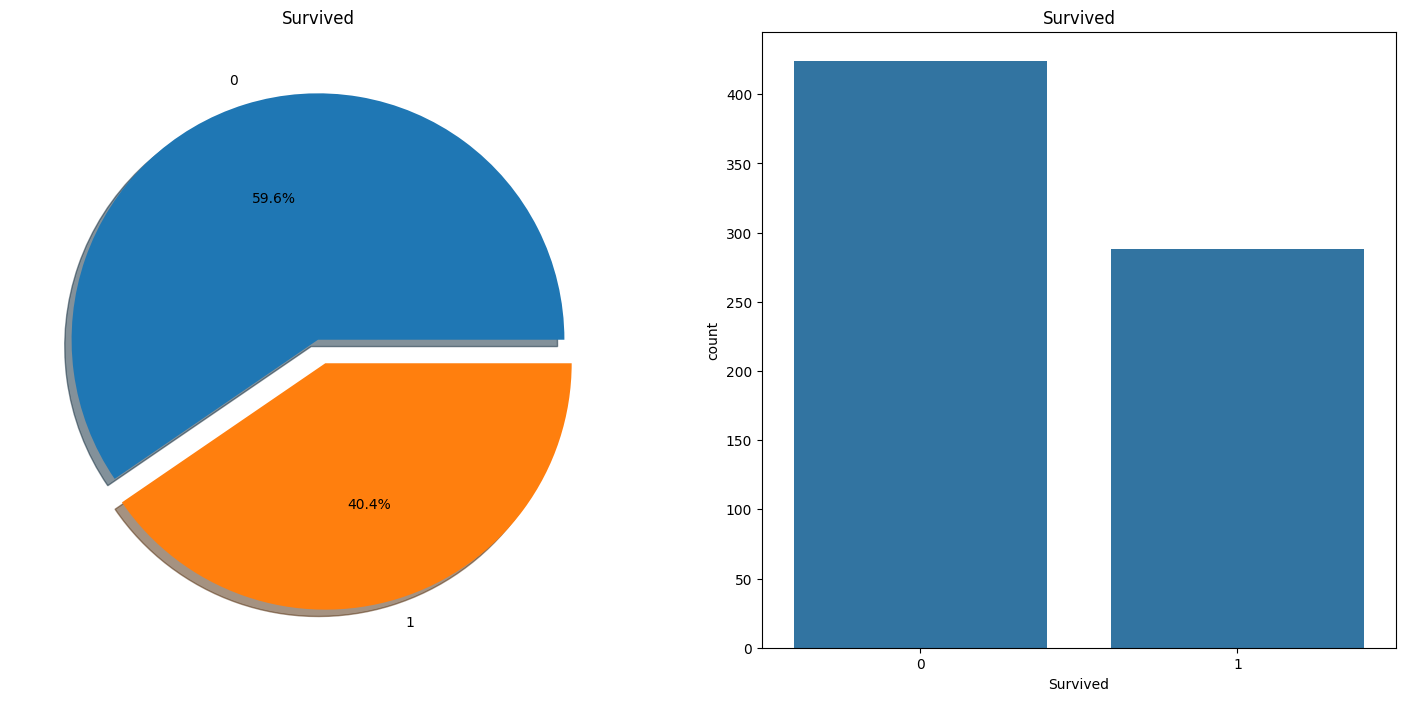

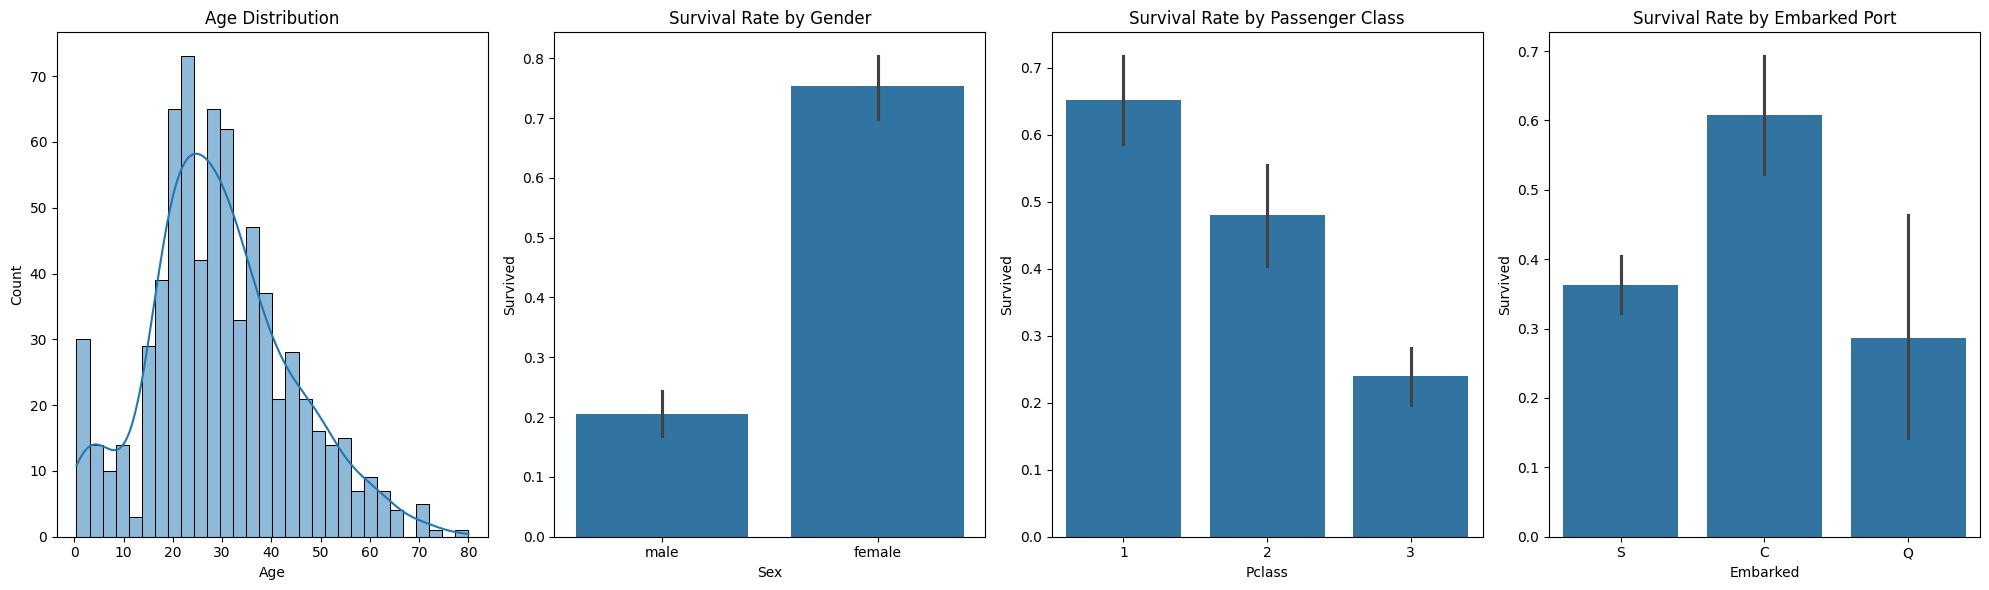

/tmp/ipykernel_16680/425639056.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  surv_counts[deck][survive] = df[deck][survive][0]


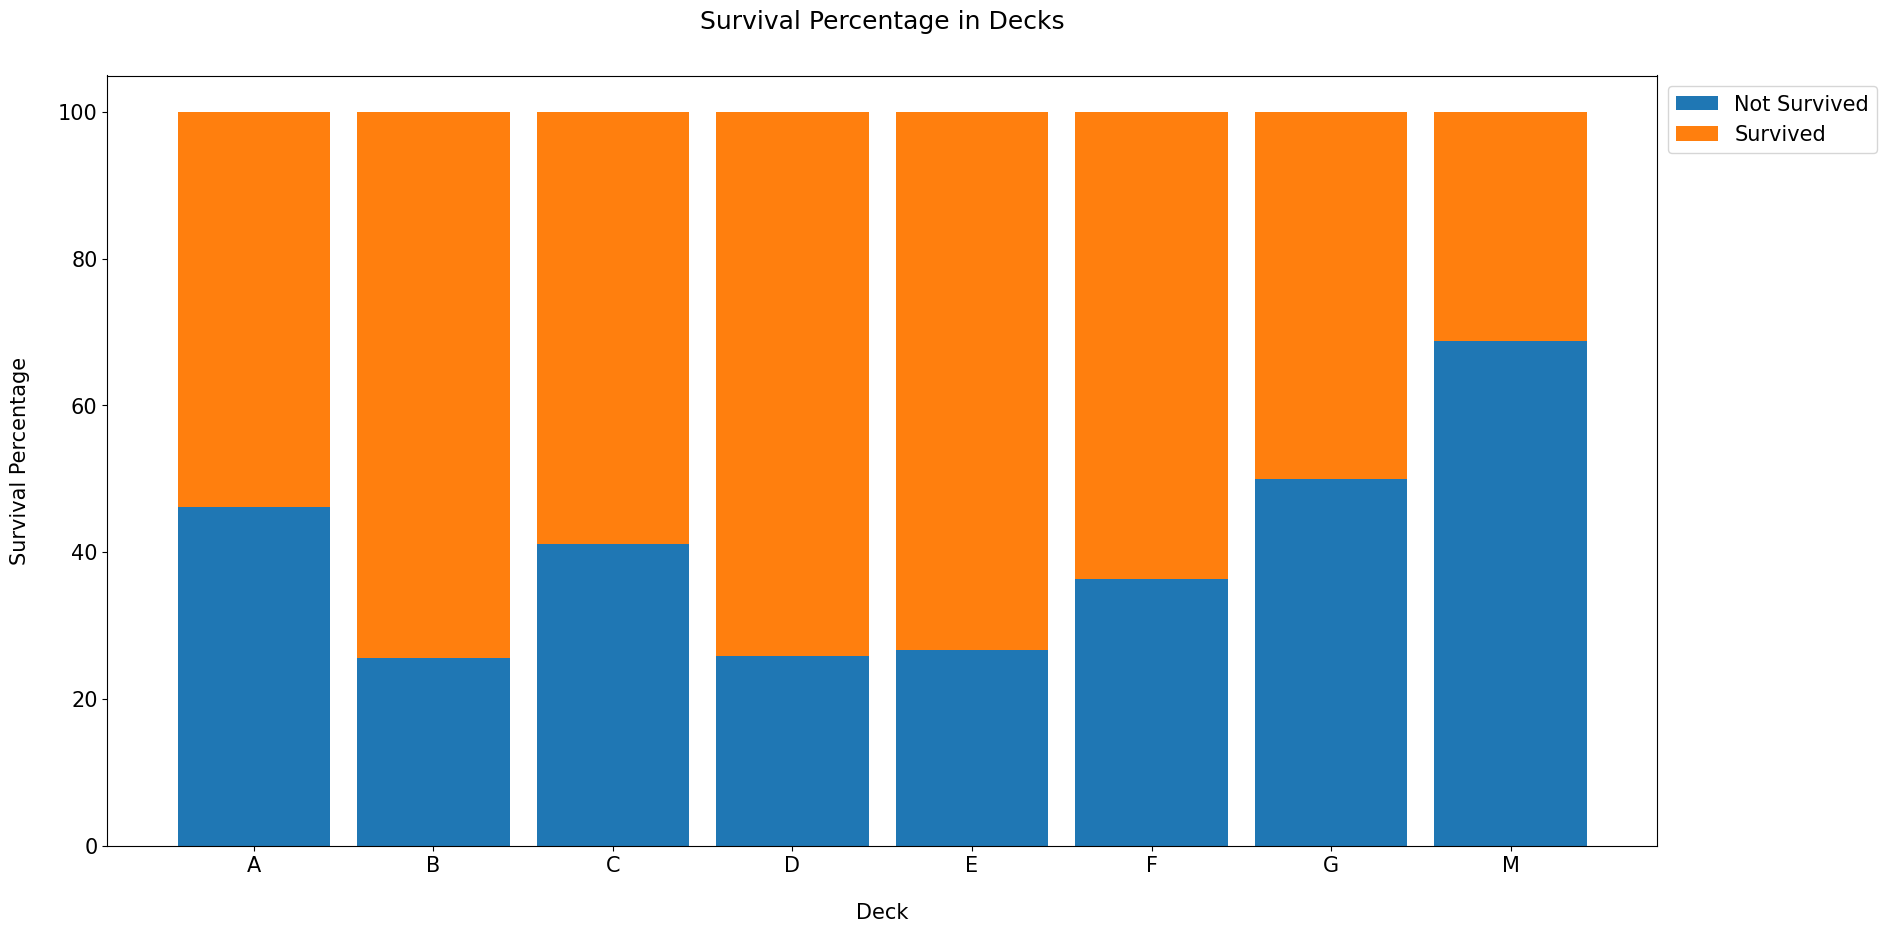

In [136]:
plot_survived_distribution(train_data)

# Set up the figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Plot the distribution of 'Age'
sns.histplot(train_data['Age'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Age Distribution')

# Survival Rate by Gender
sns.barplot(x='Sex', y='Survived', data=train_data, ax=axes[1])
axes[1].set_title('Survival Rate by Gender')

# Survival Rate by Passenger Class
sns.barplot(x='Pclass', y='Survived', data=train_data, ax=axes[2])
axes[2].set_title('Survival Rate by Passenger Class')

# Survival Rate by Embarked
sns.barplot(x='Embarked', y='Survived', data=train_data, ax=axes[3])
axes[3].set_title('Survival Rate by Embarked Port')

plt.tight_layout()
plt.show()

all_surv_count, all_surv_per = get_survived_dist(tratrain_data_decks_survived)
display_surv_dist(all_surv_per)
